In [1]:
import re, os, random
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
import torch.utils.data as data

import matplotlib.pyplot as plt
from options.options import parse_opt
from torch.utils.data import DataLoader
import cv2
%matplotlib inline

In [21]:
class FaceLandmarkDataset(data.Dataset):
    def __init__(self, opt):
        super(FaceLandmarkDataset, self).__init__()
        self.opt = opt
        self.train = (opt['phase'] == 'train')
        self.info_list = self._get_info_list(opt)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=opt['mean'], std=[1.0, 1.0, 1.0])
        ])

    def __getitem__(self, index):
        info = self.info_list[index]
        img = Image.open(info[0])
        img, landmark, landmark_original = self._resize(img, info[1])
        gt = self._generate_gt((img.size[0] // 4, img.size[1] // 4), landmark,
                               self.opt['gt_sigma'])  # C*H*W
        img, gt = self._random_modify(img, gt)
        img = self.transform(img)
        gt = torch.from_numpy(np.ascontiguousarray(gt))
        return {'img': img, 'heatmap_gt': gt, 'path': info[0], 'landmark_gt': np.array(landmark_original)}

    def __len__(self):
        return len(self.info_list)

    def _resize(self, img, landmark):
        width, height = img.size
        new_width, new_height = min(width, height), min(width, height)
        left = (width - new_width)//2
        top = (height - new_height)//2
        right = (width + new_width)//2
        bottom = (height + new_height)//2

        cropped = img.crop((left, top, right, bottom))
        resized = cropped.resize((self.opt['input_length'], self.opt['input_length']), Image.BICUBIC)
        scale_0 = 1.0 * self.opt['input_length'] / new_width
        scale = 0.25 * scale_0 # 0.25 time resolution
        landmark_original = [((x[0] - left)*scale_0, (x[1] - top)*scale_0) for x in landmark]
        landmark_resized = [(round((x[0] - left)*scale), round((x[1] - top)*scale)) for x in landmark]
        return resized, landmark_resized, landmark_original
        
    def _random_modify(self, img, gt):
        if random.random() > 0.5 and self.opt['flip_v']:
            img = img.transpose(Image.FLIP_TOP_BOTTOM)
            gt = np.flip(gt, 1)
        if random.random() > 0.5 and self.opt['flip_h']:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            gt = np.flip(gt, 2)
        if self.opt['rotate']:
            rot_rand = random.random() > 0.5
            if rot_rand > 0.75:
                img = img.transpose(Image.ROTATE_90)
                gt = np.rot90(gt, k=1, axes=(1, 2))
            elif rot_rand > 0.5:
                img = img.transpose(Image.ROTATE_180)
                gt = np.rot90(gt, k=2, axes=(1, 2))
            elif rot_rand > 0.25:
                img = img.transpose(Image.ROTATE_270)
                gt = np.rot90(gt, k=3, axes=(1, 2))
        return img, gt

    def _generate_gt(self, size, landmark_list, sigma):
        heatmap_list = [
            self._generate_one_heatmap(size, l, sigma) for l in landmark_list
        ]
        return np.stack(heatmap_list, axis=0)

    def _generate_one_heatmap(self, size, landmark, sigma):
        w, h = size
        x_range = np.arange(start=0, stop=w, dtype=int)
        y_range = np.arange(start=0, stop=h, dtype=int)
        xx, yy = np.meshgrid(x_range, y_range)
        d2 = (xx - landmark[0])**2 + (yy - landmark[1])**2
        exponent = d2 / 2.0 / sigma / sigma
        heatmap = np.exp(-exponent)
        return heatmap

    def _get_info_list(self, opt):
        info_list = []
        if opt['type'] == 'celebA':
            img_root = opt['image_root']
            with open(opt['annotation_path'], 'r') as f:
                anno_list = f.read().strip('\n').split('\n')[2:]
            with open(opt['partition_path'], 'r') as f:
                part_list = sorted(f.read().strip('\n').split('\n'))
            for i, anno in enumerate(sorted(anno_list)):
                if opt['phase'] == 'train':
                    if part_list[i][-1] != '0':
                        continue
                elif opt['phase'] == 'val':
                    if part_list[i][-1] != '1':
                        continue
                elif opt['phase'] == 'test':
                    if part_list[i][-1] != '2':
                        continue
                else:
                    raise NotImplementedError(
                        'Dataset phase %s is not recognized' % (opt['phase']))

                split = re.split('\W+', anno)
                img_name = split[0] + '.' + split[1]
                assert len(split) == opt['num_keypoints'] * 2 + 2
                landmark = []
                for i in range(opt['num_keypoints']):
                    landmark.append((int(split[2 * i + 2]), int(split[2 * i + 3])))
                info_list.append((os.path.join(img_root, img_name), landmark))
        else:
            raise NotImplementedError(
                'Dataset type %s is not recognized' % (opt['type']))
        return info_list

In [22]:
opt = parse_opt('./options/train/train_hg_check.json')
d_opt = opt['datasets']['val']
ds = FaceLandmarkDataset(d_opt)
dl = DataLoader(ds)
it = iter(dl)

In [23]:
sample = next(it)
print(sample.keys())

dict_keys(['img', 'heatmap_gt', 'path', 'landmark_gt'])


In [24]:
img = sample['img']
gt = sample['heatmap_gt']
landmark = sample['landmark_gt']
print(img.size(), gt.size(), landmark.size())

torch.Size([1, 3, 128, 128]) torch.Size([1, 5, 32, 32]) torch.Size([1, 5, 2])


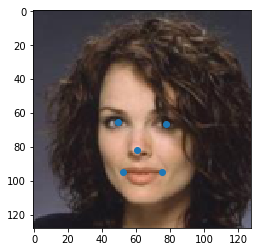

In [25]:
mean = np.array([0.509, 0.424, 0.378])
mean = np.reshape(mean, newshape=(3, 1, 1))
img_s = np.transpose(img[0].numpy() + mean, (1, 2, 0))
fig_ori = plt.figure()
plt.imshow(img_s)
plt.scatter(sample['landmark_gt'][0, :, 0], sample['landmark_gt'][0, :, 1])

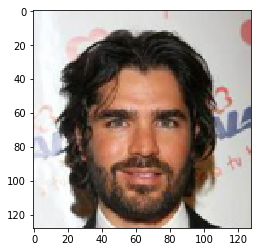

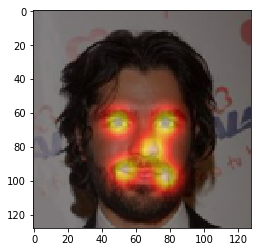

In [16]:
mean = np.array([0.509, 0.424, 0.378])
mean = np.reshape(mean, newshape=(3, 1, 1))
img_s = np.transpose(img[0].numpy() + mean, (1, 2, 0))
fig_ori = plt.figure()
plt.imshow(img_s)
fig_withhm = plt.figure()
plt.imshow(img_s)
gt_s = cv2.resize(np.mean(gt.numpy()[0], axis=0), dsize=(128, 128), interpolation=cv2.INTER_LINEAR)
plt.imshow(gt_s, cmap='hot', alpha=0.5)

In [92]:
def merge_and_scale_heatmap(heatmap, scale):
    merged = np.mean(heatmap, axis=0)
    h, w = merged.shape
    scaled = cv2.resize(merged, dsize=(h * scale, w * scale), interpolation=cv2.INTER_LINEAR)
    return scaled

In [110]:
def plot_heatmap(heatmap, img, mean, scale=4, alpha=0.5):
    '''
    merge heatmaps of different points into one heatmap
    :param heatmap: numpy array (5, 32, 32)
    :param img: image array (3, 128, 128)
    :param mean: mean rgb of dataset
    :param scale: scale factor
    :param alpha: float alpha
    '''
    scaled = merge_and_scale_heatmap(heatmap, scale)
    img_s = np.transpose(np.clip(img + mean, 0, 1), (1, 2, 0))
    fig_withhm = plt.figure()
    plt.imshow(img_s)
    plt.imshow(scaled, cmap='hot', alpha=alpha)
    plt.axis('off')
    return fig_withhm

In [120]:
def plot_heatmap_compare(heatmaps, heatmap_gt, img, mean, scale=4, alpha=0.5):
    '''
    merge heatmaps of different points into one heatmap
    :param heatmaps: list of numpy array [(5, 32, 32)]
    :param heatmap_gt: numpy array (5, 32, 32) ground truth
    :param img: image array (3, 128, 128)
    :param mean: mean rgb of dataset
    :param scale: scale factor
    :param alpha: float alpha
    '''
    scaled = [merge_and_scale_heatmap(x, scale) for x in heatmaps]
    scaled_gt = merge_and_scale_heatmap(heatmap_gt, scale)
    img_s = np.transpose(np.clip(img + mean, 0, 1), (1, 2, 0))
    img_s = np.concatenate([img_s for _ in range(len(heatmaps) + 1)], axis=1)
    scaled.insert(0, scaled_gt)
    
    scaled_s = np.concatenate(scaled, axis=1)
    fig_withhm = plt.figure()
    plt.imshow(img_s)
    plt.imshow(scaled_s, cmap='hot', alpha=alpha)
    plt.axis('off')
    return fig_withhm

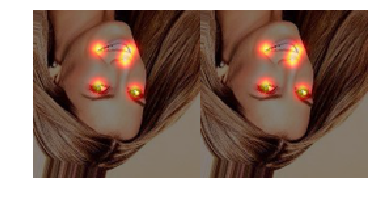

In [121]:
res = plot_heatmap_compare([gt.numpy()[0]], gt.numpy()[0], img[0].numpy(), mean)

In [123]:
res.savefig?

In [115]:
a.insert?

In [ ]:
[1, 2].insert

In [53]:
np.reshape?

In [49]:
np.max(np.mean(gt.numpy()[2], axis=0))

0.20006719524261435

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


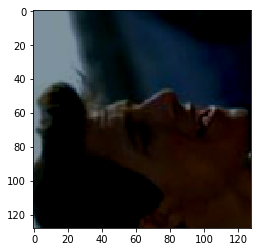

In [43]:
plt.imshow(np.transpose(img.numpy()[2], (1, 2, 0)))